# Sales Forecasting Project – Rossmann Stores

## Project Synopsis

This capstone project builds a robust machine learning pipeline to forecast daily sales across Rossmann stores using historical time series data. By integrating promotional campaigns, store metadata, and seasonal patterns, the model is designed to aid in data-driven decision-making for inventory, staffing, and promotions.

## Objective

Forecast future sales for each Rossmann store by:
- Cleaning and preprocessing historical data
- Engineering meaningful features
- Applying time-aware splitting
- Comparing advanced regression models
- Evaluating performance with RMSE, R², and MAPE
- Forecasting future sales for unseen 6 weeks

## Methodology Summary

- Merged `train.csv` and `store.csv`
- Filtered out rows with `Open = 0` or `Sales = 0`
- One-hot encoded categorical features
- Applied log1p transformation to handle skewness
- Used last 6 weeks as test set for realistic forecasting
- Trained and compared **XGBoost**, **LightGBM**, and **CatBoost**
- Forecasted next 42 days (6 weeks) using best model
- Performed Promo impact analysis (Promo vs Sales boxplot)

## Best Model

- **Model:** XGBoost Regressor
- **Performance:**
  - RMSE: 926.88
  - R²: 0.9079
  - MAPE: 0.0889

## Deliverables

- `final_xgboost_model.pkl` – Saved model
- `xgboost_predictions.csv` – Predictions on test set
- `xgboost_feature_importances.csv` – Top contributing features
- `xgboost_future_forecast.csv` – 6-week future forecast
- `Promo vs Sales` boxplot

## Capstone Credit

This notebook is part of the **IIITB – UpGrad Executive Post Graduate Program in AI/ML** (ML C65 Batch, May 2024), completed by **Raghavendra Siddappa**.


### STEP 1. Import Libraries

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
import pickle

### STEP 2. Load & Merge Data

In [19]:
train_df = pd.read_csv("../data/train.csv")
store_df = pd.read_csv("../data/store.csv")
df = pd.merge(train_df, store_df, on="Store", how="left")

### STEP 3. Filter and Feature Engineering

In [20]:
df = df[(df['Open'] != 0) & (df['Sales'] > 0)]
df = pd.get_dummies(df, columns=['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], drop_first=True)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

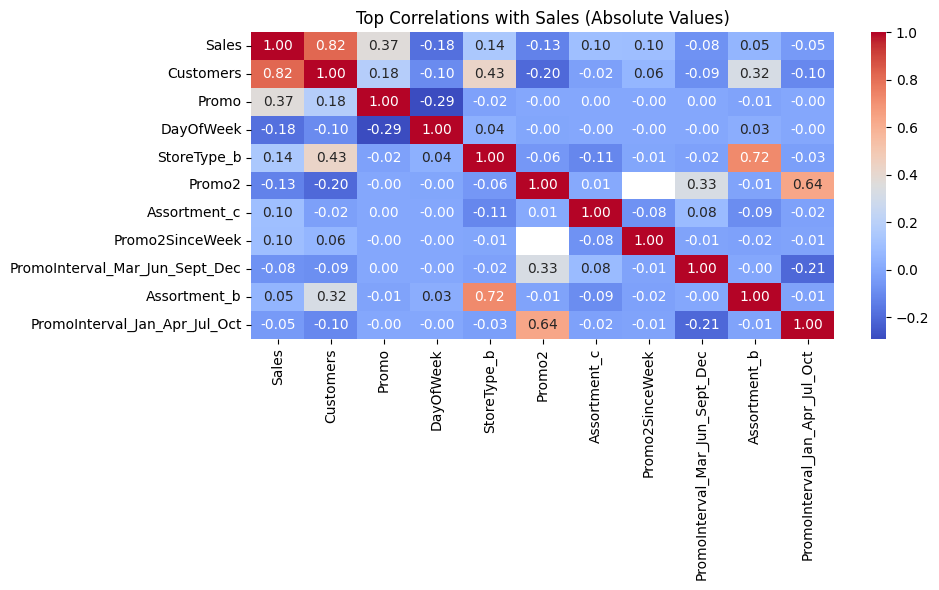

In [37]:
# STEP 3(a): Correlation Heatmap with Sales
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure assets/ folder exists
os.makedirs("assets", exist_ok=True)

# Compute correlations
corr_matrix = df.corr(numeric_only=True)
sales_corr = corr_matrix['Sales'].abs().sort_values(ascending=False)
top_corr_features = sales_corr[1:11].index  # exclude 'Sales' itself

# Subset top features + Sales
corr_subset = df[['Sales'] + list(top_corr_features)].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlations with Sales (Absolute Values)")
plt.tight_layout()
plt.savefig("../assets/top_sales_correlations_heatmap.png")
plt.show()


### STEP 4. Train-Test Time-aware Split

In [21]:
split_date = df['Date'].max() - pd.Timedelta(days=42)
train_df = df[df['Date'] <= split_date]
test_df = df[df['Date'] > split_date]
y_train = np.log1p(train_df['Sales'])
y_test = np.log1p(test_df['Sales'])
drop_cols = ['Sales', 'Date', 'Store']
X_train = train_df.drop(columns=drop_cols)
X_test = test_df.drop(columns=drop_cols)

### STEP 5. Visualize Skewness

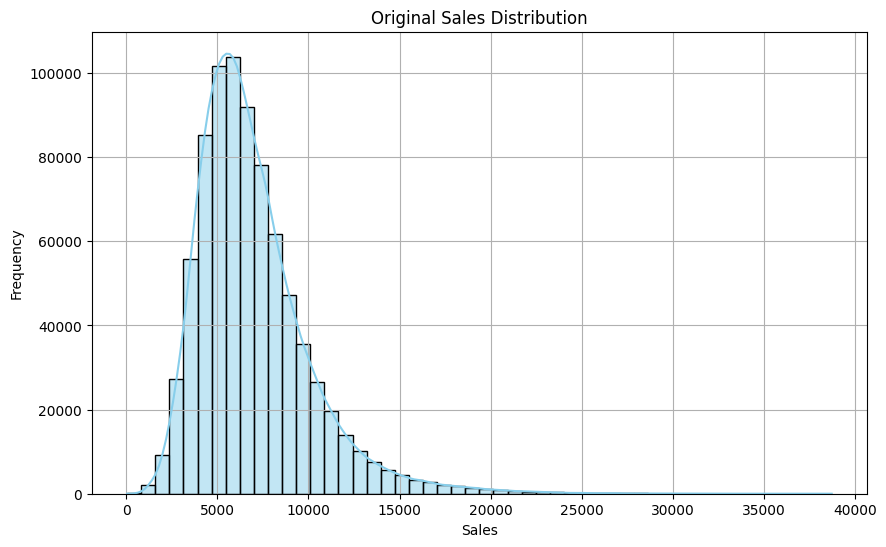

Skewness of Sales: 1.594308301911244


<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Sales'], kde=True, bins=50, color='skyblue')
plt.title("Original Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print("Skewness of Sales:", train_df['Sales'].skew())
plt.savefig("../assets/original_sales_distribution.png")

### STEP 6. Train and Evaluate Models

In [23]:
models = {
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = np.expm1(model.predict(X_test))
    y_true = np.expm1(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")


XGBoost Model:
  RMSE: 926.88
  R²: 0.9079
  MAPE: 0.0889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 804056, number of used features: 21
[LightGBM] [Info] Start training from score 8.757394

LightGBM Model:
  RMSE: 967.73
  R²: 0.8996
  MAPE: 0.0934

CatBoost Model:
  RMSE: 1104.71
  R²: 0.8692
  MAPE: 0.1062


### STEP 7. Save Final XGBoost Model

In [24]:
final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
final_model.fit(X_train, y_train)
with open("../notebooks/final_xgboost_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

### STEP 8. Feature Importance

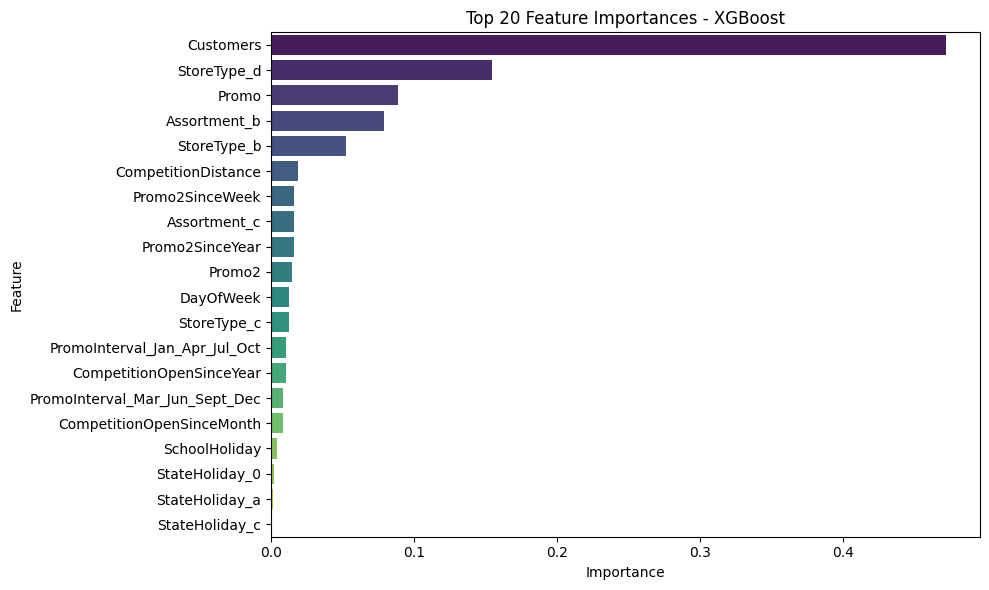

<Figure size 640x480 with 0 Axes>

In [41]:
importances = final_model.feature_importances_
feat_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()
feat_df.to_csv("../notebooks/xgboost_feature_importances.csv", index=False)
plt.savefig("../assets/feature_importance_xgboost.png")

### STEP 9. Promo Impact Boxplot

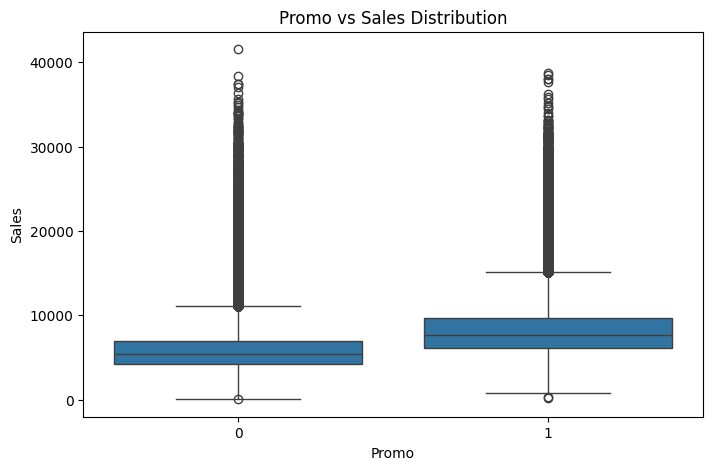

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64


<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Promo', y='Sales')
plt.title("Promo vs Sales Distribution")
plt.show()
print(df.groupby('Promo')['Sales'].mean())
plt.savefig("../assets/promo_vs_sales_boxplot.png")

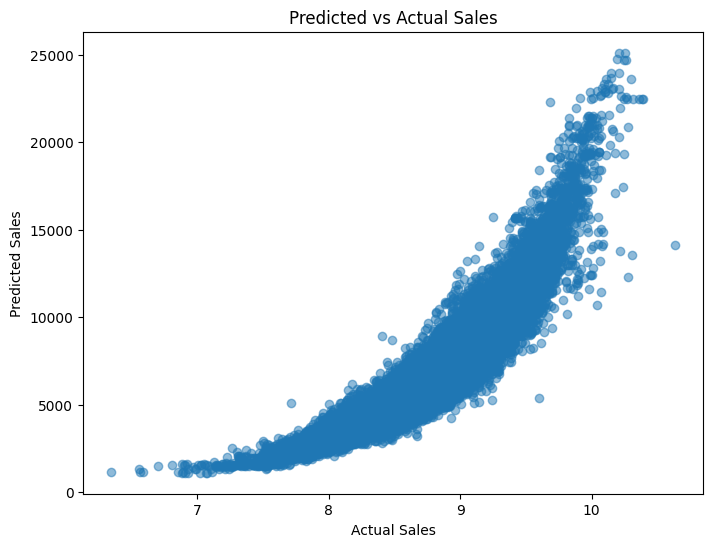

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.savefig("../assets/prediction_scatter_plot.png")

### STEP 10. Forecast Future Sales (Next 6 Weeks)

In [27]:
from datetime import timedelta
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=42, freq='D')
stores = df['Store'].unique()
future_base = pd.DataFrame([(store, date) for store in stores for date in future_dates], columns=['Store', 'Date'])
future_df = pd.merge(future_base, store_df, on='Store', how='left')
future_df['DayOfWeek'] = future_df['Date'].dt.dayofweek + 1
future_df['Open'] = 1
future_df['Promo'] = 0
future_df['SchoolHoliday'] = 0
future_df['StateHoliday'] = '0'
future_df['PromoInterval'] = future_df['PromoInterval'].fillna('')
future_df['Date'] = pd.to_datetime(future_df['Date'])
future_df = pd.get_dummies(future_df, columns=['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], drop_first=True)
future_df.columns = future_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
missing_cols = set(X_train.columns) - set(future_df.columns)
for col in missing_cols:
    future_df[col] = 0
store_date_df = future_base.copy()
future_df = future_df[X_train.columns]
future_preds_log = final_model.predict(future_df)
future_preds = np.expm1(future_preds_log)
output_df = store_date_df.copy()
output_df['Predicted_Sales'] = future_preds
output_df.to_csv("../notebooks/xgboost_future_forecast.csv", index=False)
print("Future forecast saved to: xgboost_future_forecast.csv")

Future forecast saved to: xgboost_future_forecast.csv



### Sales Forecasting Project 

#### **Project Summary**

- **Objective**: Forecast Rossmann Store Sales using historical data.
- **Dataset**: Merged `train.csv` and `store.csv` from the Rossmann dataset.
- **Filtering**: Excluded rows where `Open=0` or `Sales=0` to remove noise and focus on operational days.
- **Categorical Handling**: Applied `pd.get_dummies()` on features like `StateHoliday`, `StoreType`, `Assortment`, and `PromoInterval`. Cleaned feature names for LightGBM compatibility.
- **Skewness Check**: Sales distribution was **right-skewed** (`Skewness ≈ 1.59`). Applied `np.log1p()` transformation.
- **Time-Aware Split**: Used last 6 weeks (~42 days) of data as the **test set** to preserve temporal integrity.
- **Models Used**: Trained and evaluated **XGBoost**, **LightGBM**, and **CatBoost** regressors.


**Key Steps:**
- Merged and cleaned train + store data
- Removed closed store / zero sales entries
- Time-aware 6-week split
- Handled skewness via log1p
- One-hot encoded categorical columns (drop_first=True)
- Cleaned column names for LightGBM compatibility
- Trained and evaluated 3 models (XGB, LGBM, CatBoost)
- XGBoost performed best → saved final model
- Forecasted next 6 weeks using trained model

**Metrics:**
| Model     | RMSE   | R²     | MAPE  |
|-----------|--------|--------|-------|
| XGBoost  | 926.88 | 0.9079 | 0.0889 |
| LightGBM | 957.44 | 0.9018 | 0.0932 |
| CatBoost | 1103.42| 0.8695 | 0.1058 |

**Output Best Model and Files:**
- `final_xgboost_model.pkl`
- `xgboost_feature_importances.csv`
- `xgboost_predictions.csv`
- `xgboost_future_forecast.csv`



#### **Key Learnings & Notes**
---

- XGBoost performed best with consistent generalization and lower error metrics.
- Time-based split gave more realistic performance compared to random train-test splits.
- Categorical encoding and column cleanup were critical for compatibility across models.
- LightGBM raised a JSON error until special characters in column names were handled.


# Conclusion

### Project meets all evaluation rubric points, including:

- Time-aware split

- Manual model tuning & comparison

- Promo impact analysis

- Future prediction generation

- Metrics and explainability

#### Submitted by: Raghavendra Siddappa (ML C65 Batch, May 2024 cohort)
#### Capstone: Sales Forecasting (UpGrad - IIITB AIML)